# Object-Specific Decoder Analysis

Analyze the object-specific decoder pipeline: load samples, compute quantized latents with synthetic anomalies (same logic as stage2 training), then visualize **before subspace restriction** (q), **after subspace restriction** (F̃), **after quantization** (frozen codebook), and **reconstructed spectrogram** (x_s).

## 1. Setup and model loading

Paths, imports, build and load sDSR from checkpoints (same pattern as anomaly_mask_analysis). Optional DATA_PATH for the dataset.

In [5]:
# Setup and paths
import sys
from pathlib import Path

_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

CKPT_DIR = PROJECT_ROOT / "checkpoints"
MACHINE_TYPE = "fan"
STAGE1_CKPT = CKPT_DIR / "stage1" / MACHINE_TYPE / "stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt"
STAGE2_CKPT = CKPT_DIR / "stage2" / MACHINE_TYPE / "stage2_fan_best.pt"
DATA_PATH = "/mnt/ssd/LaCie/dcase2020-task2-dev-dataset"  # Set to e.g. "/path/to/dcase2020-task2-dev-dataset" to load real data

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_mels, T = 128, 320
BATCH_SIZE = 4

def get_q_shape(n_mels, T):
    return (max(1, n_mels // 4), max(1, T // 4))

q_shape = get_q_shape(n_mels, T)
H_q, W_q = q_shape[0], q_shape[1]
print(f"Device: {DEVICE}, n_mels={n_mels}, T={T}, q_shape={q_shape}")

Device: cuda, n_mels=128, T=320, q_shape=(32, 80)


In [7]:
# Build and load sDSR
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer
from src.models.sDSR.s_dsr import sDSR, sDSRConfig

def build_vq_vae(n_mels, T):
    return VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(4096, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )

def build_s_dsr(vq_vae, n_mels, T):
    return sDSR(vq_vae, sDSRConfig(
        embedding_dim=128, num_hiddens=128,
        num_residual_layers=2, num_residual_hiddens=64,
        n_mels=n_mels, T=T,
        use_subspace_restriction=False,  # required for aux recon_feat_* and F̃/q_r visualization
    ))

vq_vae = build_vq_vae(n_mels, T)
if STAGE1_CKPT.exists():
    ckpt_s1 = torch.load(STAGE1_CKPT, map_location="cpu", weights_only=False)
    vq_vae.load_state_dict(ckpt_s1["model_state_dict"])
model = build_s_dsr(vq_vae, n_mels, T)
if STAGE2_CKPT.exists():
    ckpt_s2 = torch.load(STAGE2_CKPT, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt_s2["model_state_dict"])
else:
    print("Stage2 checkpoint not found; using random weights (signal-flow demo only).")
model = model.to(DEVICE)
model.eval()
print("Model ready (eval mode).")

Model ready (eval mode).


## 2. Load samples

If DATA_PATH is set, use DCASE2020Task2LogMelDataset; otherwise create a small batch of synthetic spectrograms so the notebook runs and documents the pipeline.

In [8]:
if DATA_PATH is not None:
    from torch.utils.data import DataLoader
    from src.data.dataset import DCASE2020Task2LogMelDataset
    ds = DCASE2020Task2LogMelDataset(root=DATA_PATH, machine_type=MACHINE_TYPE, normalize=True)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    x, _, _ = next(iter(loader))
    x = x.to(DEVICE)
    print(f"Loaded batch from dataset: x.shape = {x.shape}")
else:
    # Synthetic spectrograms for pipeline demo
    x = torch.randn(BATCH_SIZE, 1, n_mels, T, device=DEVICE) * 0.5
    x = F.avg_pool2d(x, 3, stride=1, padding=1)  # smooth
    print(f"Synthetic batch: x.shape = {x.shape}")

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
Loaded batch from dataset: x.shape = torch.Size([4, 1, 128, 320])


## 3. Quantized latents and synthetic anomalies (stage2 logic)

Replicate the randomized anomaly logic from s_dsr.forward_train: encode, build M (half zeros, half from anomaly map generator), anomaly_generation, then per-sample use_both/use_lo to form q_top_final, q_bot_final (decoder inputs).

In [9]:
batch_size = x.shape[0]
half = batch_size // 2
device = x.device

# Encode
with torch.no_grad():
    q_bot, q_top, z_bot, z_top = model._vq_vae.encode_with_prequant(x)
vq_bot = model._vq_vae._vq_bot
vq_top = model._vq_vae._vq_top

# M: half zeros, half anomaly maps
M_zeros = torch.zeros(half, 1, q_shape[0], q_shape[1], device=device)
M_anom = model._anomaly_map_generator.generate(batch_size - half, device, force_anomaly=True)
M = torch.cat([M_zeros, M_anom], dim=0)

# Strengths and anomaly generation
strength_bot = torch.rand(batch_size, device=device) * (model.config.anomaly_strength_max - model.config.anomaly_strength_min) + model.config.anomaly_strength_min
strength_top = torch.rand(batch_size, device=device) * (model.config.anomaly_strength_max - model.config.anomaly_strength_min) + model.config.anomaly_strength_min
q_bot_a, q_top_a = model._anomaly_generation(
    q_bot, q_top, M, vq_bot, vq_top,
    z_bot=z_bot, z_top=z_top,
    strength_bot=strength_bot, strength_top=strength_top,
)

# Per-sample randomization (use_both, use_lo)
use_both = torch.randint(0, 2, (batch_size,), device=device).float().view(batch_size, 1, 1, 1)
use_lo = torch.randint(0, 2, (batch_size,), device=device).float().view(batch_size, 1, 1, 1)
use_both_anom = use_both[half:]
use_lo_anom = use_lo[half:]
q_bot_final_anom = use_both_anom * q_bot_a[half:] + (1 - use_both_anom) * (use_lo_anom * q_bot[half:] + (1 - use_lo_anom) * q_bot_a[half:])
q_top_final_anom = use_both_anom * q_top_a[half:] + (1 - use_both_anom) * (use_lo_anom * q_top_a[half:] + (1 - use_lo_anom) * q_top[half:])

q_top_final = torch.cat([q_top[:half], q_top_final_anom], dim=0)
q_bot_final = torch.cat([q_bot[:half], q_bot_final_anom], dim=0)
print(f"Decoder inputs: q_top_final {q_top_final.shape}, q_bot_final {q_bot_final.shape}")

Decoder inputs: q_top_final torch.Size([4, 128, 16, 40]), q_bot_final torch.Size([4, 128, 32, 80])


## 4. Run object decoder and get intermediates

Call object_decoder with return_aux=True to get x_s and recon_feat_top/bot (F̃). Compute quantized F̃ (q_top_r, q_bot_r) via the frozen VQ layers.

In [10]:
with torch.no_grad():
    x_s, aux = model._object_decoder(
        q_top_final, q_bot_final,
        model._vq_vae._vq_top, model._vq_vae._vq_bot,
        return_aux=True,
    )

# Subspace outputs (empty aux when use_subspace_restriction=False)
if "recon_feat_top" in aux and "recon_feat_bot" in aux:
    recon_feat_top = aux["recon_feat_top"]
    recon_feat_bot = aux["recon_feat_bot"]
    _, q_top_r, _, _ = model._vq_vae._vq_top(recon_feat_top)
    _, q_bot_r, _, _ = model._vq_vae._vq_bot(recon_feat_bot)
    use_subspace = True
else:
    # Fallback when decoder was built without subspace: use decoder input as stand-in
    recon_feat_top = q_top_final
    recon_feat_bot = q_bot_final
    q_top_r = q_top_final
    q_bot_r = q_bot_final
    use_subspace = False
    print("Note: use_subspace_restriction was False; showing q_final as F̃/q_r stand-in.")

print("Stages: before_sub (q_final) -> F̃ (recon_feat) -> after_quant (q_r) -> x_s")
print(f"  q_top_final {q_top_final.shape}, recon_feat_top {recon_feat_top.shape}, q_top_r {q_top_r.shape}, x_s {x_s.shape}")

Note: use_subspace_restriction was False; showing q_final as F̃/q_r stand-in.
Stages: before_sub (q_final) -> F̃ (recon_feat) -> after_quant (q_r) -> x_s
  q_top_final torch.Size([4, 128, 16, 40]), recon_feat_top torch.Size([4, 128, 16, 40]), q_top_r torch.Size([4, 128, 16, 40]), x_s torch.Size([4, 1, 128, 320])


## 5. Visualize and describe

For one or two samples (index 0 = normal, one from second half = anomalous): input spectrogram, before subspace (q), after subspace (F̃), after quantization (q_r), reconstructed spectrogram (x_s). Captions describe each stage.

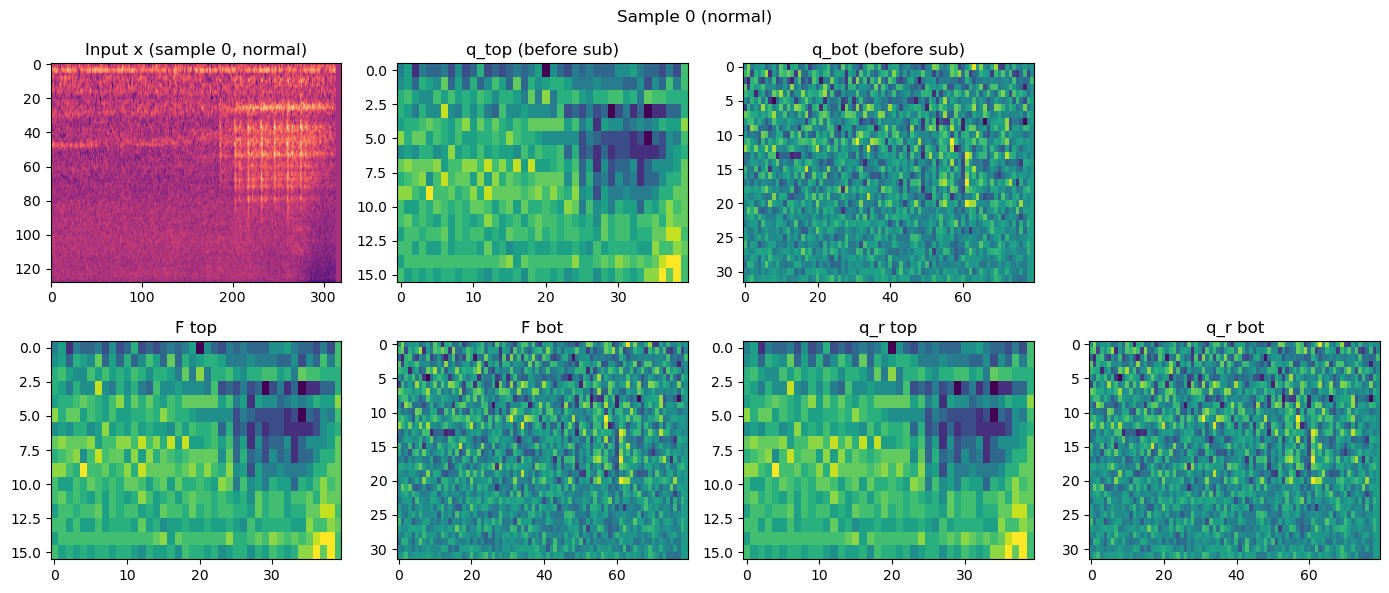

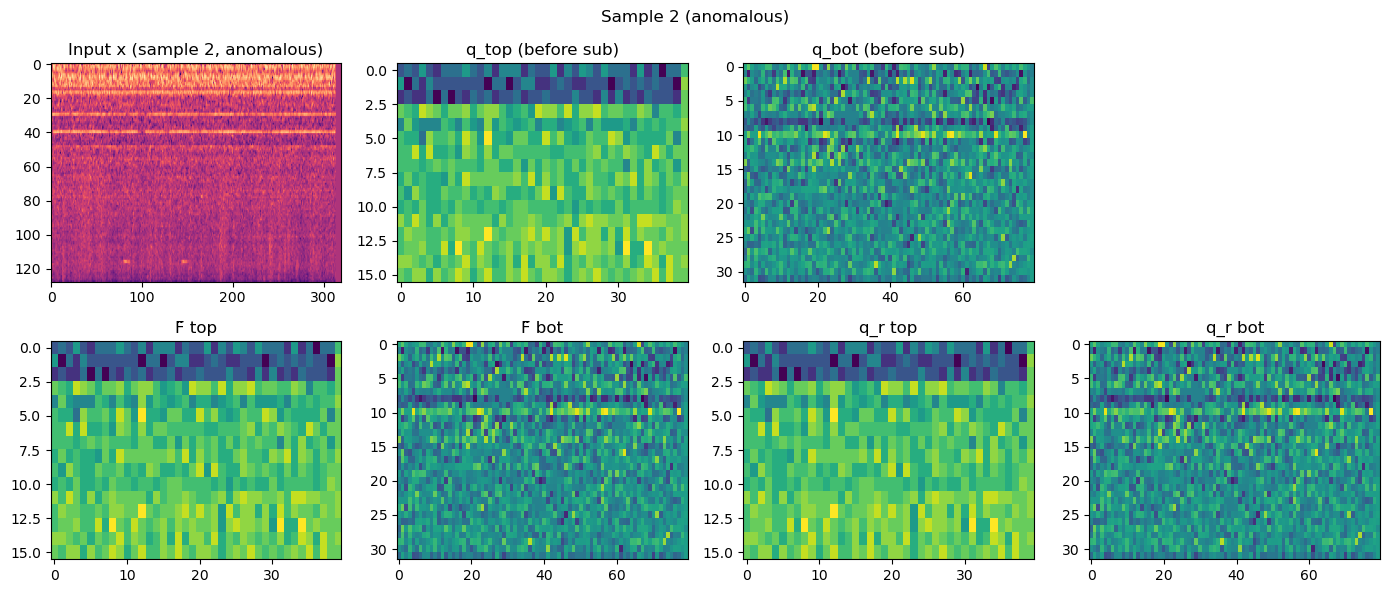

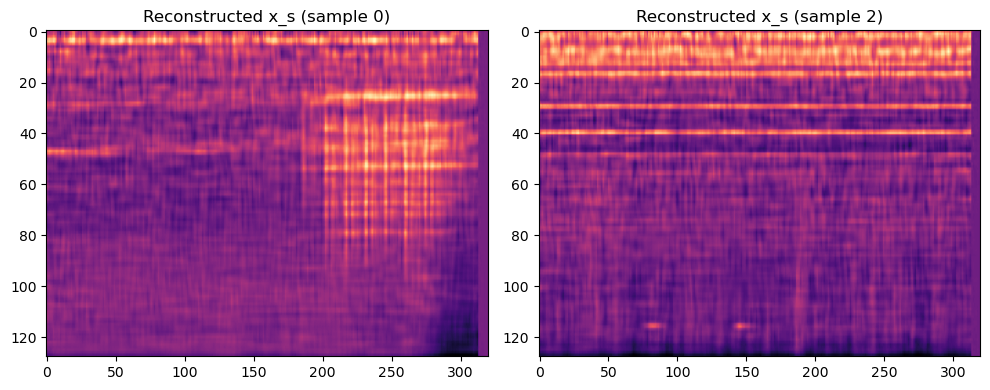

In [11]:
def plot_latent_2d(lat, title, ax, reduce="mean"):
    """lat: (C, H, W); show as 2D by reducing over channel."""
    if reduce == "mean":
        img = lat.detach().cpu().float().mean(0).numpy()
    else:
        img = lat.detach().cpu().float()[0].numpy()
    ax.imshow(img, aspect="auto", cmap="viridis")
    ax.set_title(title)

samples_to_show = [0, half] if batch_size > half else [0]  # normal (0) and one anomalous (second half)
for s in samples_to_show:
    label = "normal" if s < half else "anomalous"
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    # Input spectrogram
    axes[0, 0].imshow(x[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[0, 0].set_title(f"Input x (sample {s}, {label})")
    # Before subspace
    plot_latent_2d(q_top_final[s], "q_top (before sub)", axes[0, 1])
    plot_latent_2d(q_bot_final[s], "q_bot (before sub)", axes[0, 2])
    axes[0, 3].axis("off")
    # After subspace (F̃)
    plot_latent_2d(recon_feat_top[s], "F̃ top", axes[1, 0])
    plot_latent_2d(recon_feat_bot[s], "F̃ bot", axes[1, 1])
    # After quantization
    plot_latent_2d(q_top_r[s], "q_r top", axes[1, 2])
    plot_latent_2d(q_bot_r[s], "q_r bot", axes[1, 3])
    plt.suptitle(f"Sample {s} ({label})")
    plt.tight_layout()
    plt.show()

# Reconstructed spectrogram
fig, axes = plt.subplots(1, len(samples_to_show), figsize=(5 * len(samples_to_show), 4))
if len(samples_to_show) == 1:
    axes = [axes]
for i, s in enumerate(samples_to_show):
    axes[i].imshow(x_s[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[i].set_title(f"Reconstructed x_s (sample {s})")
plt.tight_layout()
plt.show()

**Stage descriptions:**  
- **Before subspace:** Decoder input q_top_final, q_bot_final (quantized latents, possibly anomaly-augmented).  
- **F̃ (after subspace restriction):** UNet output in latent space (recon_feat_top/bot).  
- **After quantization:** q_top_r, q_bot_r = quantized(F̃) with frozen stage1 codebook.  
- **x_s:** Final reconstructed spectrogram from SpectrogramReconstructionNetwork.

## 5b. General decoder output (x_g)

The **general decoder** (frozen VQ-VAE from stage1) decodes the same quantized latents `q_bot_final`, `q_top_final` into **x_g**. Unlike the object-specific decoder (x_s), it does not apply subspace restriction, so x_g reflects the anomalies present in the latents. Plot x_g for the same samples as above for comparison with input x and object-decoder output x_s.

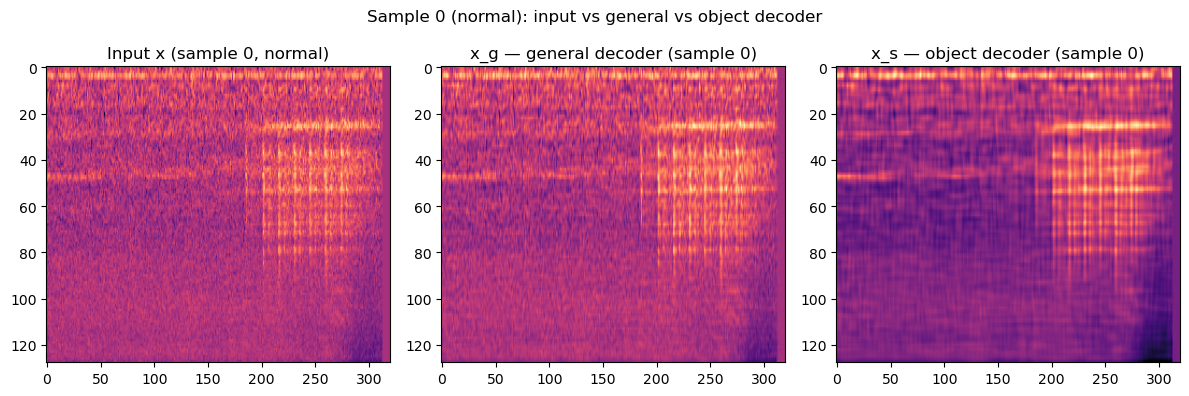

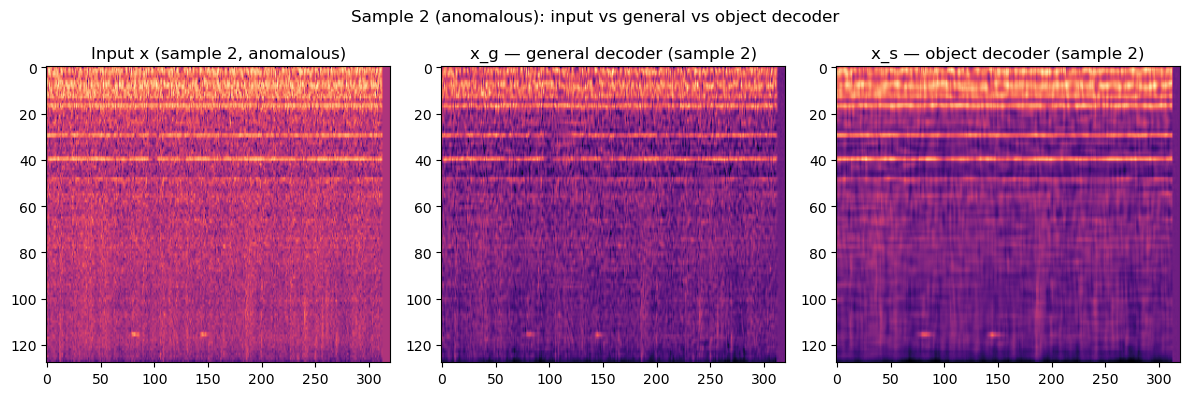

In [12]:
# General decoder: same latents -> x_g (with anomalies)
with torch.no_grad():
    x_g = model._vq_vae.decode_general(q_bot_final, q_top_final)

# Compare x (input), x_g (general decoder), x_s (object decoder) for the same samples
for s in samples_to_show:
    label = "normal" if s < half else "anomalous"
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(x[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[0].set_title(f"Input x (sample {s}, {label})")
    axes[1].imshow(x_g[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[1].set_title(f"x_g — general decoder (sample {s})")
    axes[2].imshow(x_s[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[2].set_title(f"x_s — object decoder (sample {s})")
    plt.suptitle(f"Sample {s} ({label}): input vs general vs object decoder")
    plt.tight_layout()
    plt.show()

## 5c. Anomaly detection network (step-by-step)

The anomaly detection module takes **x_g** and **x_s** and predicts a segmentation mask (normal vs anomaly):

1. **Input:** Concatenate x_g and x_s over the channel dimension → `(B, 2, n_mels, T)` (channel 0 = x_g, channel 1 = x_s).
2. **Network:** A UNet (encoder + decoder) processes this 2-channel image.
3. **Output:** **m_out** has shape `(B, 2, n_mels, T)` — logits for the two classes (normal, anomaly). The anomaly decision at each pixel comes from these logits (e.g. argmax or softmax probability of the anomaly class).

During stage2 training, **focal loss** is used to train this module: the ground-truth anomaly map **M** (the same mask used to generate synthetic anomalies) is compared to **m_out** so the network learns to segment anomalous regions from the (x_g, x_s) pair.

In [13]:
# Step 1: Concatenate x_g and x_s on channel dimension -> (B, 2, n_mels, T)
x_concat = torch.cat([x_g, x_s], dim=1)
print(f"Concatenated input to anomaly detection: x_concat shape = {x_concat.shape}  (ch0=x_g, ch1=x_s)")

# Step 2 & 3: Forward through anomaly detection module -> m_out (B, 2, n_mels, T) logits
with torch.no_grad():
    m_out = model._anomaly_detection(x_g, x_s)
print(f"Anomaly detection output (logits): m_out shape = {m_out.shape}  (ch0=normal, ch1=anomaly)")

# Anomaly probability map: softmax then take anomaly channel
m_probs = F.softmax(m_out, dim=1)
anomaly_prob = m_probs[:, 1:2]  # (B, 1, n_mels, T)

Concatenated input to anomaly detection: x_concat shape = torch.Size([4, 2, 128, 320])  (ch0=x_g, ch1=x_s)
Anomaly detection output (logits): m_out shape = torch.Size([4, 2, 128, 320])  (ch0=normal, ch1=anomaly)


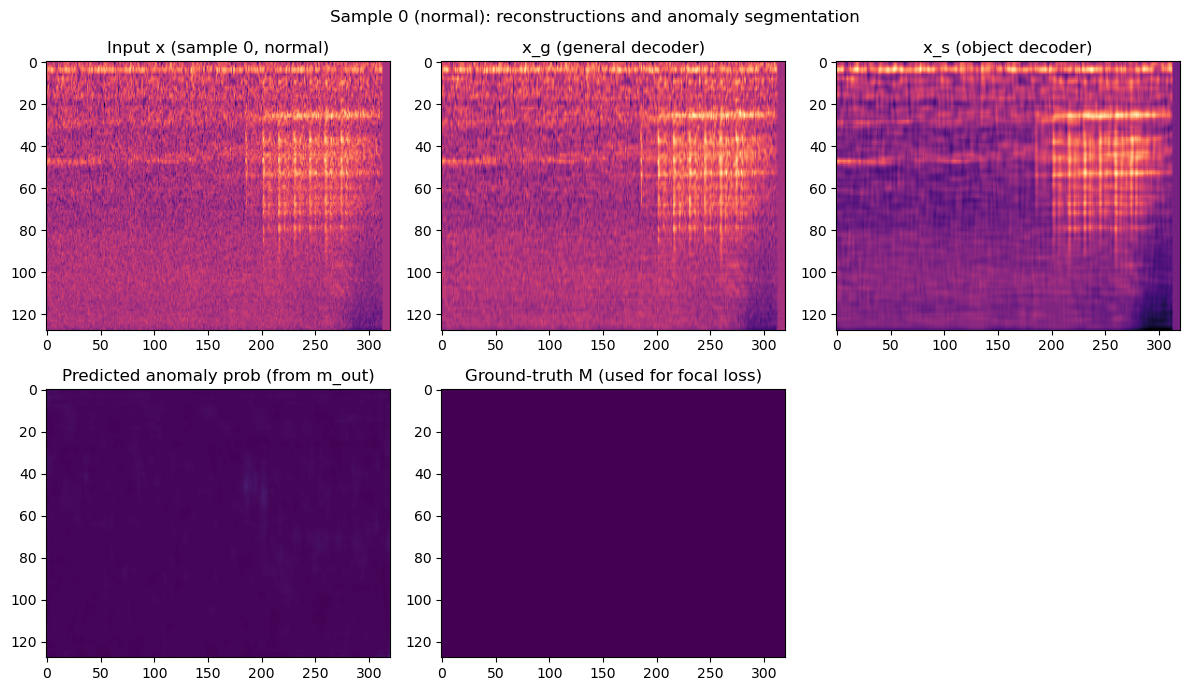

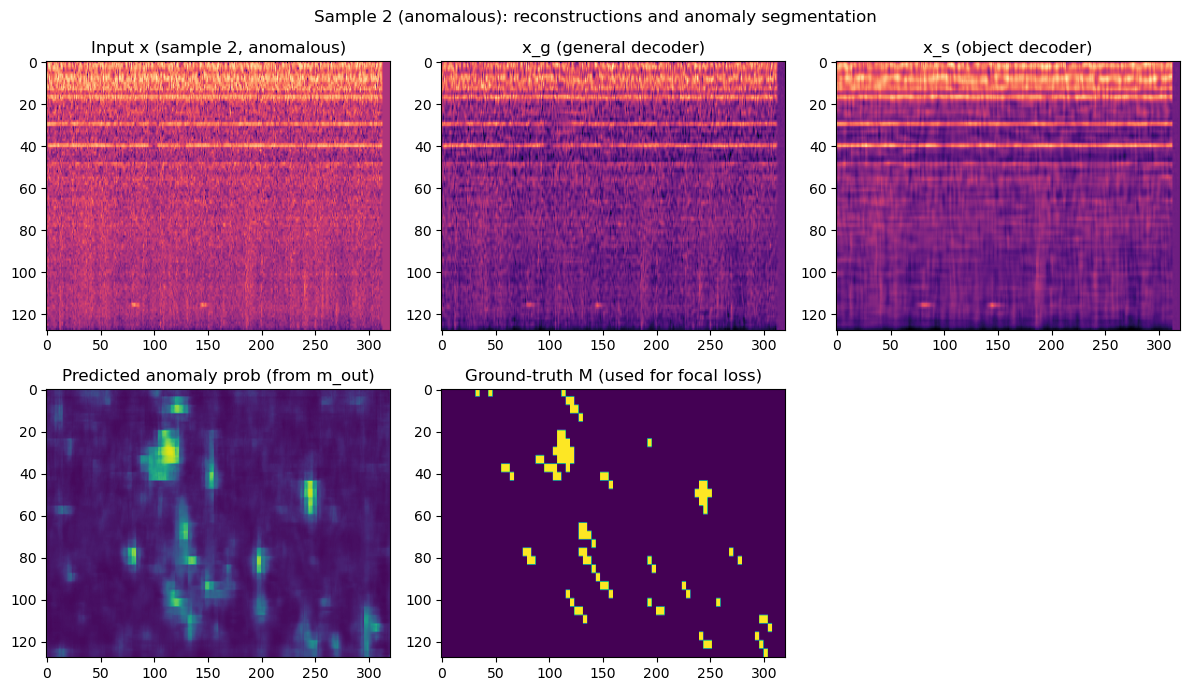

In [14]:
# Visualize: for the same samples, show input x, x_g, x_s, predicted anomaly prob, and (optional) ground-truth M
M_at_spec = F.interpolate(M.float(), size=(n_mels, T), mode="nearest")  # M used in anomaly generation, at spectrogram size

for s in samples_to_show:
    label = "normal" if s < half else "anomalous"
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    axes[0, 0].imshow(x[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[0, 0].set_title(f"Input x (sample {s}, {label})")
    axes[0, 1].imshow(x_g[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[0, 1].set_title("x_g (general decoder)")
    axes[0, 2].imshow(x_s[s, 0].cpu().numpy(), aspect="auto", cmap="magma")
    axes[0, 2].set_title("x_s (object decoder)")
    axes[1, 0].imshow(anomaly_prob[s, 0].cpu().numpy(), aspect="auto", cmap="viridis", vmin=0, vmax=1)
    axes[1, 0].set_title("Predicted anomaly prob (from m_out)")
    axes[1, 1].imshow(M_at_spec[s, 0].cpu().numpy(), aspect="auto", cmap="viridis", vmin=0, vmax=1)
    axes[1, 1].set_title("Ground-truth M (used for focal loss)")
    axes[1, 2].axis("off")
    plt.suptitle(f"Sample {s} ({label}): reconstructions and anomaly segmentation")
    plt.tight_layout()
    plt.show()

**Focal loss (training):** In stage2, the trainer computes `loss_focal = FocalLoss(m_out, M)`. The ground-truth **M** is the same anomaly map used to build the synthetic anomalies (resized to spectrogram size). Focal loss down-weights easy pixels and focuses on hard ones, so the anomaly detection network learns to segment anomalous regions from the (x_g, x_s) pair.

### Compare anomaly detection criteria (from m_out)

Different ways to turn the per-pixel anomaly probability into a single score per sample: **max**, **mean**, **percentiles**, or **fraction above threshold**. Compare these criteria across the batch (normal vs anomalous half).

Anomaly criteria per sample (from predicted anomaly probability):


,sample,label,max,mean,median,p95,p99,frac_gt_0.5,frac_gt_0.3
0,0,normal,0.123960,0.016603,0.015589,0.025524,0.034526,0.000000,0.000000
1,1,normal,0.072954,0.015174,0.014558,0.022509,0.028860,0.000000,0.000000
2,2,anomalous,0.959229,0.108712,0.070600,0.323873,0.699717,0.024878,0.056592
3,3,anomalous,0.858066,0.099096,0.083719,0.204702,0.352894,0.002856,0.016333


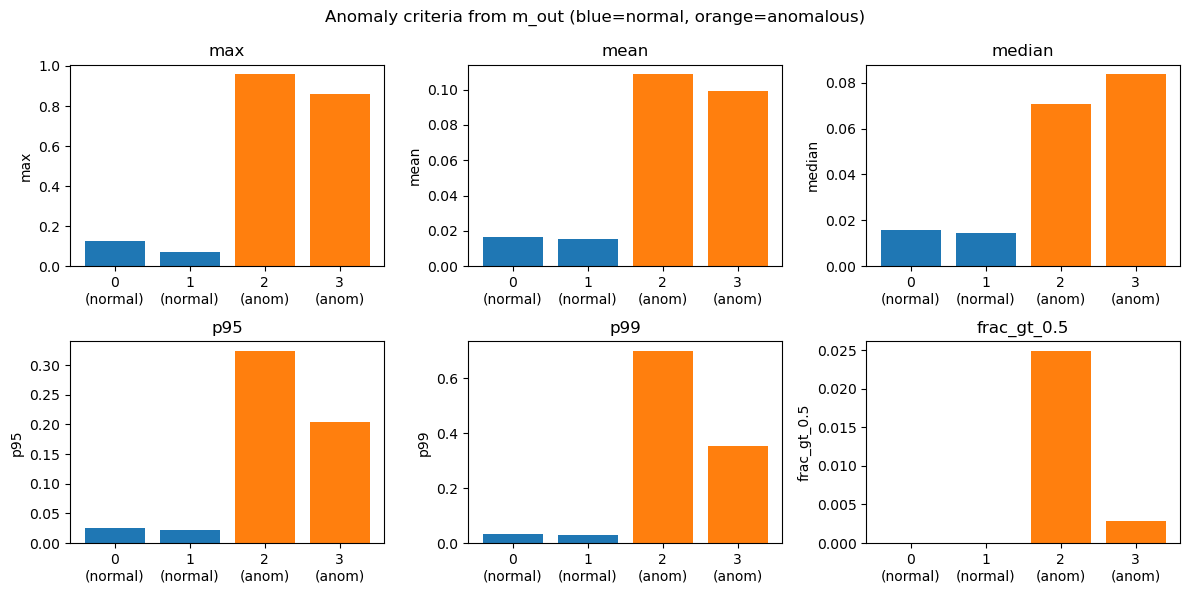

In [15]:
# Per-sample anomaly probability map: (B, 1, n_mels, T)
p = anomaly_prob[:, 0]  # (B, n_mels, T)

# Aggregate criteria per sample (over spatial dims)
criteria = {
    "max": p.flatten(1).max(dim=1).values,
    "mean": p.flatten(1).mean(dim=1),
    "median": p.flatten(1).median(dim=1).values,
    "p95": p.flatten(1).quantile(0.95, dim=1),
    "p99": p.flatten(1).quantile(0.99, dim=1),
    "frac_gt_0.5": (p > 0.5).float().flatten(1).mean(dim=1),
    "frac_gt_0.3": (p > 0.3).float().flatten(1).mean(dim=1),
}

# Table: one row per sample, columns = criteria
import pandas as pd
rows = []
for b in range(batch_size):
    row = {"sample": b, "label": "normal" if b < half else "anomalous"}
    for name, vals in criteria.items():
        row[name] = vals[b].item()
    rows.append(row)
df = pd.DataFrame(rows)
print("Anomaly criteria per sample (from predicted anomaly probability):")
display(df)

# Bar plot: compare criteria for the same samples we plotted (normal vs anomalous)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()
for i, (name, vals) in enumerate(criteria.items()):
    if i >= len(axes):
        break
    ax = axes[i]
    v = vals.cpu().numpy()
    colors = ["C0" if b < half else "C1" for b in range(batch_size)]
    ax.bar(range(batch_size), v, color=colors)
    ax.set_xticks(range(batch_size))
    ax.set_xticklabels([f"{b}\n({'normal' if b < half else 'anom'})" for b in range(batch_size)])
    ax.set_ylabel(name)
    ax.set_title(name)
plt.suptitle("Anomaly criteria from m_out (blue=normal, orange=anomalous)")
plt.tight_layout()
plt.show()

## 6. Optional: numerical summary

Shapes of key tensors; optionally L2(recon_feat, q_r) to illustrate F̃ projected to codebook.

In [16]:
print("Shape summary:")
print(f"  x: {x.shape}")
print(f"  q_top_final, q_bot_final: {q_top_final.shape}, {q_bot_final.shape}")
print(f"  recon_feat_top, recon_feat_bot: {recon_feat_top.shape}, {recon_feat_bot.shape}")
print(f"  q_top_r, q_bot_r: {q_top_r.shape}, {q_bot_r.shape}")
print(f"  x_s: {x_s.shape}")

# L2 distance F̃ vs q_r (per sample, mean over spatial)
l2_top = (recon_feat_top - q_top_r).pow(2).sum(dim=1).sqrt().mean(dim=(1, 2))  # (B,)
l2_bot = (recon_feat_bot - q_bot_r).pow(2).sum(dim=1).sqrt().mean(dim=(1, 2))
print(f"L2(recon_feat, q_r) per sample — top: {l2_top.cpu().numpy().round(4)}, bot: {l2_bot.cpu().numpy().round(4)}")

Shape summary:
  x: torch.Size([4, 1, 128, 320])
  q_top_final, q_bot_final: torch.Size([4, 128, 16, 40]), torch.Size([4, 128, 32, 80])
  recon_feat_top, recon_feat_bot: torch.Size([4, 128, 16, 40]), torch.Size([4, 128, 32, 80])
  q_top_r, q_bot_r: torch.Size([4, 128, 16, 40]), torch.Size([4, 128, 32, 80])
  x_s: torch.Size([4, 1, 128, 320])
L2(recon_feat, q_r) per sample — top: [0. 0. 0. 0.], bot: [0. 0. 0. 0.]
